In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 데이터 불러오기
trn = pd.read_csv('data/train.csv')
tst = pd.read_csv('data/test.csv')

In [3]:
## 365 변환
def days_to_plus(x):
    return (x*-1)/365

## 업무 시작일 변환
def plus(x):
    if x<0:
        return x*(-1)
    else:
        return 0

## 나이 양수로 변환
trn['birth_plus'] = trn.DAYS_BIRTH.map(days_to_plus)
tst['birth_plus'] = tst.DAYS_BIRTH.map(days_to_plus)
    
## 업무시작일 양수로 변환
trn['employed_plus'] = trn.DAYS_EMPLOYED.map(days_to_plus)
tst['employed_plus'] = tst.DAYS_EMPLOYED.map(days_to_plus)

In [4]:
index_col = 'index'
target_col = 'credit'

cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
float_cols = [x for x in trn.columns.drop('credit') if trn[x].dtype == 'float64']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]
feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

21 8 13


In [5]:
from sklearn.preprocessing import LabelEncoder

lbe = LabelEncoder()
for i in cat_cols:
    trn[i] = lbe.fit_transform(trn[i].astype(str))
    tst[i] = lbe.transform(tst[i].astype(str))
    
for i in float_cols:
    trn[i] = trn[i].astype('int')
    tst[i] = tst[i].astype('int')

In [6]:
## 인덱스 설정
trn.set_index('index', inplace = True)
tst.set_index('index', inplace = True)

In [7]:
trn.credit = trn.credit.astype('category')

In [8]:
trn6 = trn.drop(['family_size', 'employed_plus'], axis = 1).copy()

In [9]:
## 연봉 제곱 변수 제거
trn6['income_total_2'] = trn6.income_total**2
tst['income_total_2'] = tst.income_total**2

## DAYS_BIRTH 제곱 변수 추가
trn6['DAYS_BIRTH**2'] = trn6.DAYS_BIRTH**2
tst['DAYS_BIRTH**2'] = tst.DAYS_BIRTH**2

## income * days_birth
trn6['income_age']=trn6.income_total*trn6.DAYS_BIRTH
tst['income_age']=tst.income_total*tst.DAYS_BIRTH

## income * DAYS_EMPLOYED
trn6['income_emp']=trn6.income_total*trn6.DAYS_EMPLOYED
tst['income_emp']=tst.income_total*tst.DAYS_EMPLOYED

In [10]:
print(trn6.shape)

(26457, 23)


<AxesSubplot:xlabel='income_total_2', ylabel='Density'>

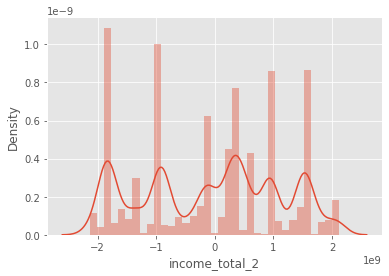

In [42]:
sns.distplot(trn6.income_total_2**2, label = i)

# RF 최고기록

In [10]:
## 조합 9차시도 : 

trn6.income_total = np.log1p(trn6.income_total)
# trn6['DAYS_BIRTH**2'] = np.log1p(trn6['DAYS_BIRTH**2'])
trn6.income_total_2 = trn6.income_total_2**2
trn6.income_emp = trn6.income_emp**2
trn6.income_age = trn6.income_age**3


tst.income_total = np.log1p(tst.income_total)
# tst['DAYS_BIRTH**2'] = np.log1p(tst['DAYS_BIRTH**2'])
tst.income_total_2 = tst.income_total_2**2
tst.income_emp = tst.income_emp**2
tst.income_age = tst.income_age**3

In [11]:
trn6.income_total = trn6.income_total.astype(int)
trn6['DAYS_BIRTH**2'] = trn6['DAYS_BIRTH**2'].astype(int)

tst.income_total = tst.income_total.astype(int)
tst['DAYS_BIRTH**2'] = tst['DAYS_BIRTH**2'].astype(int)

In [12]:
### 이 기록은 라벨인코딩을 따로 지정하지 않고 한번에 돌린 데이터
### trn6은 trn6 = trn.drop(['family_size', 'employed_plus'], axis = 1).copy()이다.
### 총 18개의 변수를 사용한 것 -> 최고기록

## predict_rf
ftr = trn6.drop('credit', axis=1).values
target = trn['credit'].values
tst_ar = tst.drop(['family_size', 'employed_plus'], axis = 1).values
n_class = 3
n_fold = 10

print(ftr.shape)
print(tst_ar.shape)


cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=40)

rf_p_val = np.zeros((ftr.shape[0], n_class))
rf_p_tst = np.zeros((tst_ar.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr, target), 1):
    print(f'training model for CV #{i}')
    rf_clf = RandomForestClassifier(n_estimators = 7000, 
                                random_state=2021,
                                max_features = 3,
                                min_samples_split = 8,
                                n_jobs=2)
    rf_clf.fit(ftr[i_trn], target[i_trn])
    rf_p_val[i_val, :] = rf_clf.predict_proba(ftr[i_val])
    rf_p_tst += rf_clf.predict_proba(tst_ar) / n_fold
    
print(f'{log_loss(target, rf_p_val)}')
print(f'{confusion_matrix(target, np.argmax(rf_p_val, axis=1))}%')

(26457, 22)
(10000, 22)
training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
training model for CV #6
training model for CV #7
training model for CV #8
training model for CV #9
training model for CV #10
0.6858634231403249
[[  712   523  1987]
 [  139  2985  3143]
 [  345   876 15747]]%


In [63]:
sub = pd.read_csv('data/sample_submission.csv', index_col = 0)
sub
sub[sub.columns] = rf_p_tst

In [64]:
sub.to_csv('data/DAYS_BIRTH제곱만 로그 변환 안 함.csv')

1. trn6.income_age**(3) 으로 했을 때가 0.6866962841415036
2. trn6.income_age**13 으로 했을 때가 0.6873255407581582
*정규분포 형태와 아닌 형태로 대칭인 것만 같고 조금 다름*
=> 직사각형이 더 좋음
3. trn6.income_age 변환 안 함 : 0.6884951810307259
4. tst.income_emp 변환 안 함 :0.6874159266024837
5. trn6.income_total_2 변환 안 함 : 0.686115792094735
6. trn6.income_total_2**2 : 0.6860332046797343 => 가장 높은 성능

---

# 0.6858826235417401




trn6.income_total = np.log1p(trn6.income_total)
(주석)# trn6['DAYS_BIRTH**2'] = np.log1p(trn6['DAYS_BIRTH**2'])
trn6.income_total_2 = trn6.income_total_2**2
trn6.income_emp = trn6.income_emp**2
trn6.income_age = trn6.income_age**3


for i in ['income_total','DAYS_BIRTH**2']:
   tst[i] = np.log1p(tst[i])
tst.income_total = np.log1p(tst.income_total)
(주석)# tst['DAYS_BIRTH**2'] = np.log1p(tst['DAYS_BIRTH**2'])
tst.income_total_2 = tst.income_total_2**2
tst.income_emp = tst.income_emp**2
tst.income_age = tst.income_age**3